# Time series forecasting
Get data from weather logging, and try to predict some parameters. Data is found online.
Example is from keras/tensorflow

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Downloading the data

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

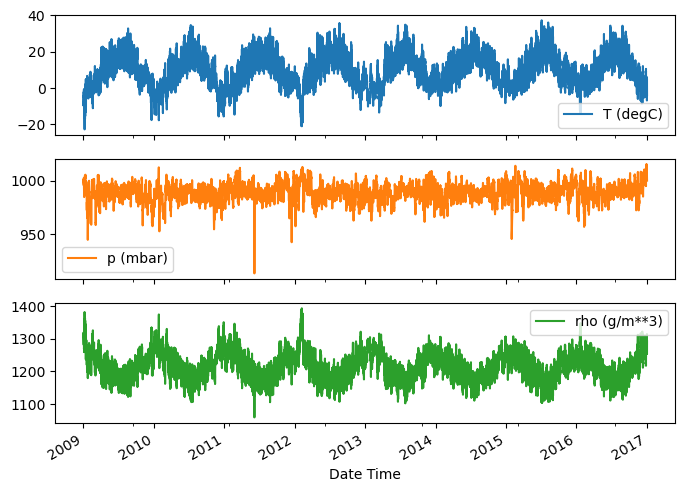

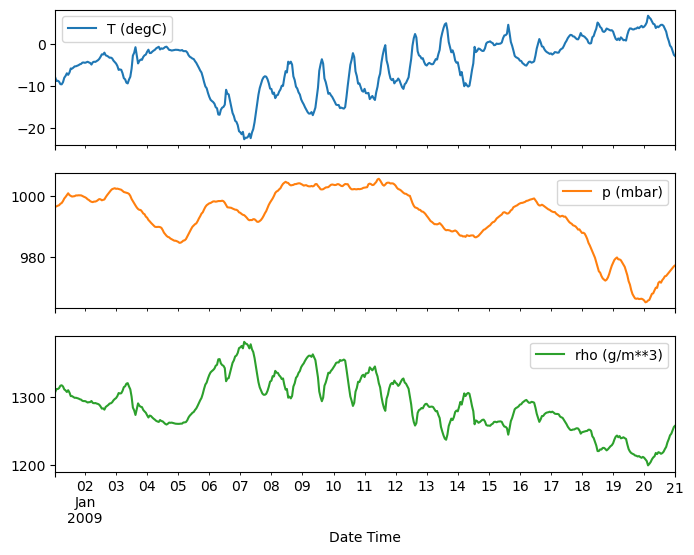

In [4]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], and we want every 60 minutes, i.e. once every hour, starting from the 5th value
df=df[5::6]
date_time= pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.head()
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [5]:
# Look at some statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [6]:
# Since we have an error in the wv min column/row, we'll remove it and replace it with 0
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

## Preprocessing
We want to change some of the formatting of the data so that we can use it.
This includes moving to radians instead of degrees, and go from datetime as a string to seconds.

In [7]:
# Remove headers
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
# Load seconds 
timestamp_s = date_time.map(pd.Timestamp.timestamp)

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

# Map seconds to a periodic signal(sin/cos)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

## Assumption/justification
There is an assumption that the parameters heavily depend upon time of day and year, which is logical. 
We will justify this assumption by looking at the data as signals, and use FFT to see where there is varuiations.
If the assumption is correct, we will have spikes over the frequencies corresponding to a year and a day in the spectrum.

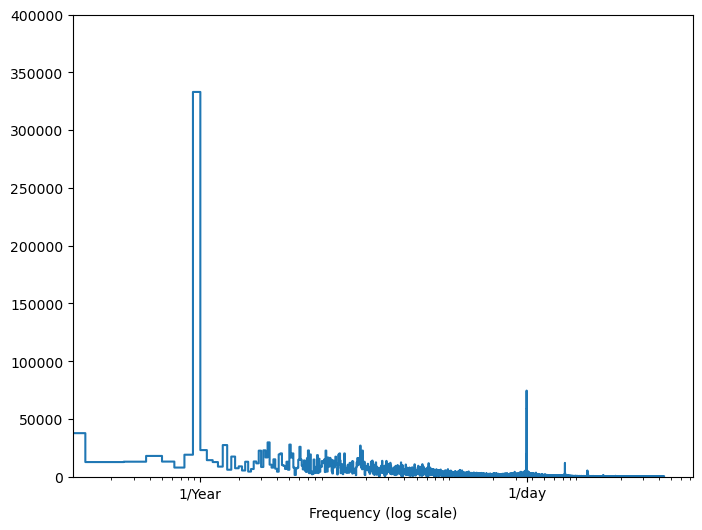

In [8]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

## Data split
We will use 70% of the data to train, 20% to validate, and 10% to test 

In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df=df[0:int(n*0.7)]
val_df=df[int(n*0.7):int(n*(0.7+0.2))]
test_df=df[int(n*0.9):]
num_features=df.shape[1]
print(f'we have {num_features} features')

we have 19 features


 ## Normalization
 We also need to normalize the dtaa so that it is usable.
 This is done by subtracting the mean and dividing by the standard deviation of each feature.
 To do this properly, we need to divide all the sets by the same eman, and we'll use the training mean/std for this

In [10]:
train_mean=train_df.mean()
train_std=train_df.std()

train_df=(train_df - train_mean)/train_std
val_df=(val_df - train_mean)/train_std
test_df=(test_df - train_mean)/train_std


In [11]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')


## Data windowing
We'll create a WindowGenerator class that can handle our windowing for all inputs and all models

In [12]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [13]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [14]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs) # I think this is the step where we predict the labels
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()
    plt.grid()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [15]:
# creating two instances of the class to test
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w1
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [16]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


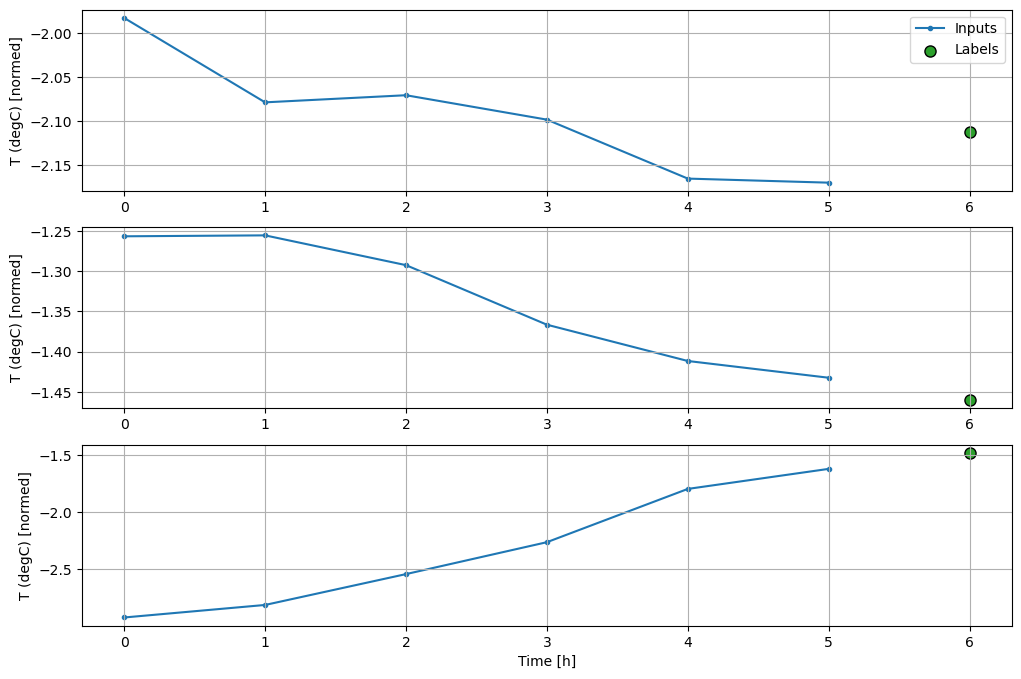

In [17]:
w2.example = example_inputs, example_labels
w2.plot()

In [18]:
# Creating tf.data.datasets out of the time series dataframe
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [19]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [20]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [21]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

# Baseline model
We will build a baseline to compare other methods to: we wish to predict the temperature one hour into the future based upon the current value of all features.


In [22]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        results = inputs[:,:,self.label_index]
        return results[:,:,tf.newaxis]


In [23]:
# Create the baseline model:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),metrics=[tf.metrics.MeanAbsoluteError()])
val_performance={}
performance={}
val_performance['Baseline']=baseline.evaluate(single_step_window.val)
performance['Baseline']=baseline.evaluate(single_step_window.test,verbose=0)


439/439 [==============================] - 2s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


In [24]:
wide_window=WindowGenerator(
    input_width=24, label_width= 24, shift=1, label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

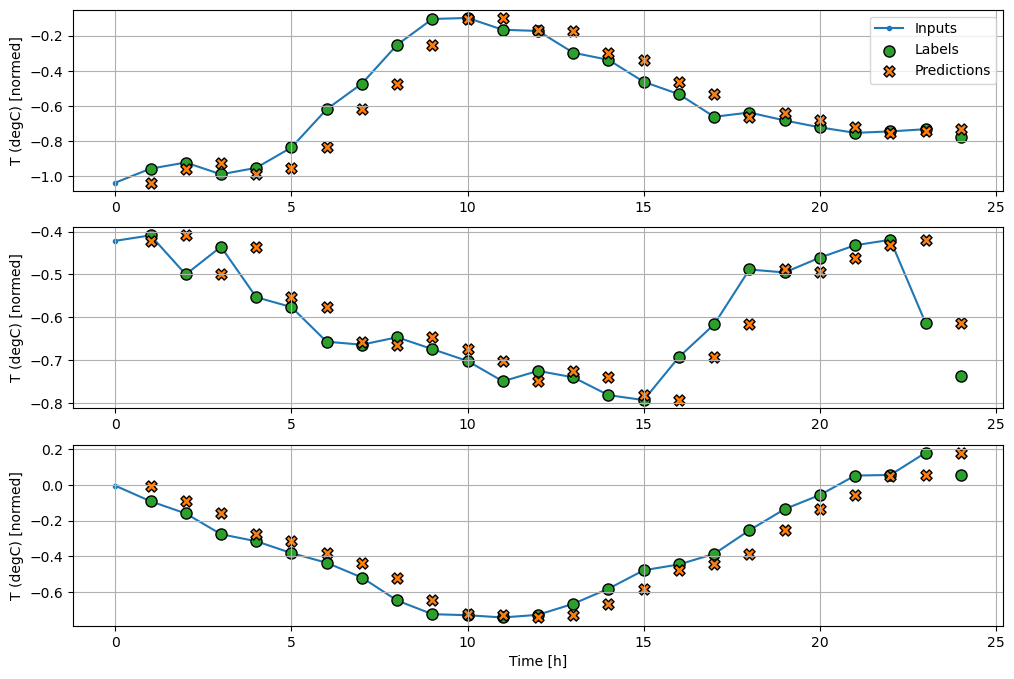

In [25]:
wide_window.plot(baseline)

## Linear model
We now know how the baseline looks, simply reguessing the last label on temperature.
We will now use a trainable model, and we start with the simplest method, being linear.

In [26]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


### Training
Thius will be packaged into a function

In [27]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

## Train and evaluate the linear model

In [28]:
history = compile_and_fit(linear,single_step_window)
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 6s 3ms/step - loss: 0.2146 - mean_absolute_error: 0.2723 - val_loss: 0.0181 - val_mean_absolute_error: 0.0979
Epoch 2/20
1534/1534 [==============================] - 4s 2ms/step - loss: 0.0129 - mean_absolute_error: 0.0847 - val_loss: 0.0109 - val_mean_absolute_error: 0.0773
Epoch 3/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0104 - mean_absolute_error: 0.0752 - val_loss: 0.0097 - val_mean_absolute_error: 0.0726
Epoch 4/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0096 - mean_absolute_error: 0.0721 - val_loss: 0.0091 - val_mean_absolute_error: 0.0704
Epoch 5/20
1534/1534 [==============================] - 4s 3ms/step - loss: 0.0093 - mean_absolute_error: 0.0707 - val_loss: 0.0089 - val_mean_absolute_error: 0.0700
Epoch 6/20
1534/1534 [==============================] - 4s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0702 - val_loss: 0.0089 - val_mean_absolute_error: 0.0702
Epoc

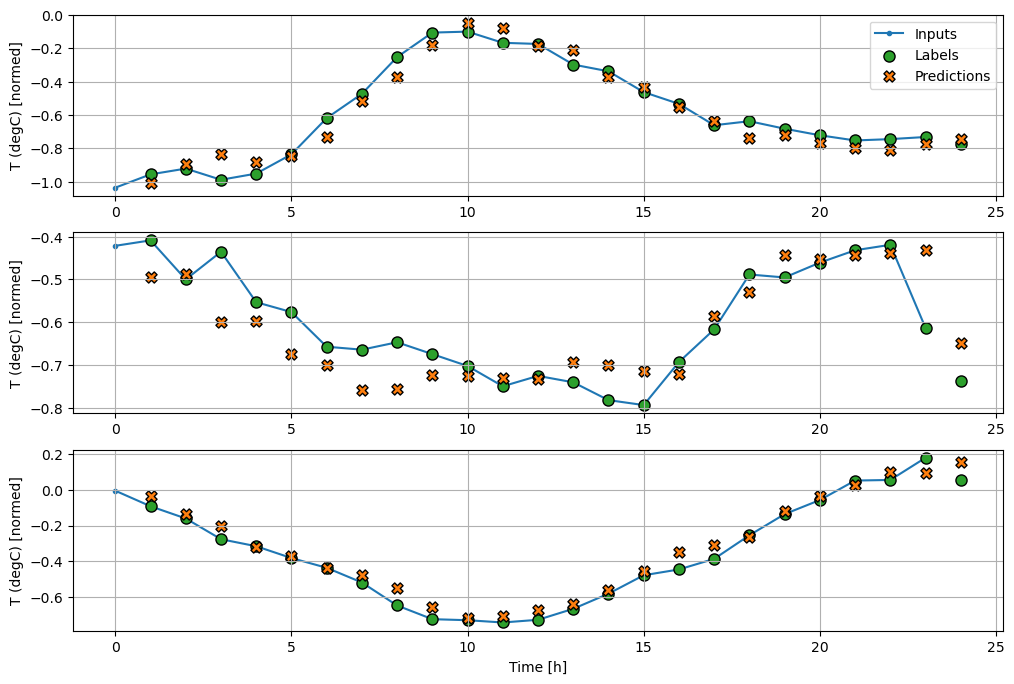

In [29]:
wide_window.plot(linear)

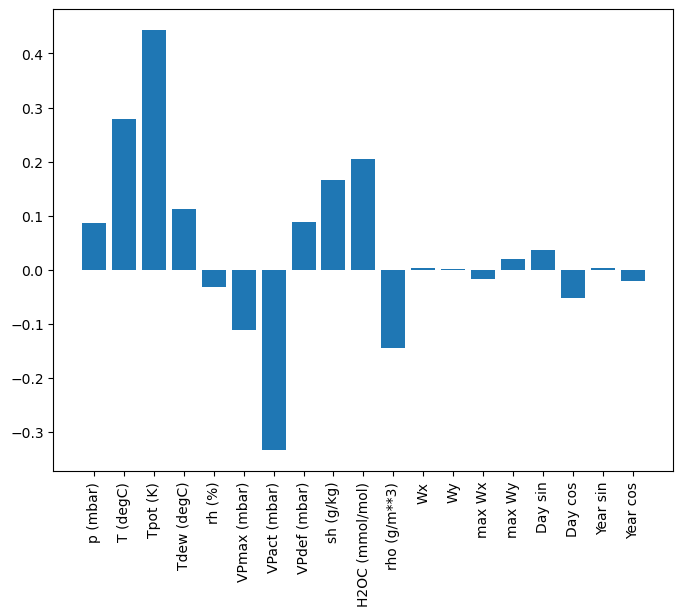

In [30]:
# looking at the weights
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## A dense model
A model with some dense layers between the input and the output

In [31]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 9s 5ms/step - loss: 0.0153 - mean_absolute_error: 0.0809 - val_loss: 0.0075 - val_mean_absolute_error: 0.0622
Epoch 2/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0079 - mean_absolute_error: 0.0647 - val_loss: 0.0072 - val_mean_absolute_error: 0.0602
Epoch 3/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0075 - mean_absolute_error: 0.0626 - val_loss: 0.0069 - val_mean_absolute_error: 0.0583
Epoch 4/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0073 - mean_absolute_error: 0.0611 - val_loss: 0.0073 - val_mean_absolute_error: 0.0614
Epoch 5/20
439/439 [==============================] - 1s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0630


## Multi step dense model
We will change it to multiple inputs being requried for a single predictino, i.e. three steps in one out.

In [32]:
CONV_WIDTH=3
conv_window = WindowGenerator(input_width=CONV_WIDTH,label_width=1,shift=1,label_columns=['T (degC)'])
conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

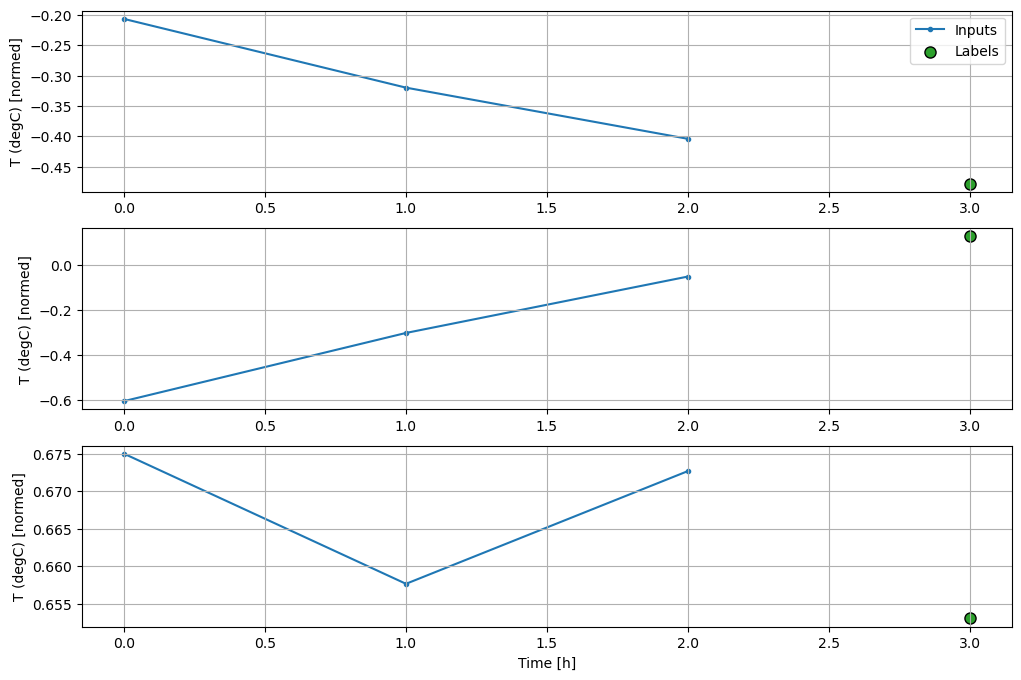

In [33]:
conv_window.plot()

In [34]:
# Adding a flatten layer to enable multiple inputs
multi_step_dense = tf.keras.Sequential([tf.keras.layers.Flatten(),
tf.keras.layers.Dense(units=32,activation='relu'),
tf.keras.layers.Dense(units=32,activation='relu'),
tf.keras.layers.Dense(units=1),
tf.keras.layers.Reshape([1,-1]),
])

In [35]:
history = compile_and_fit(multi_step_dense,conv_window)
IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 1s 2ms/step - loss: 0.0072 - mean_absolute_error: 0.0623


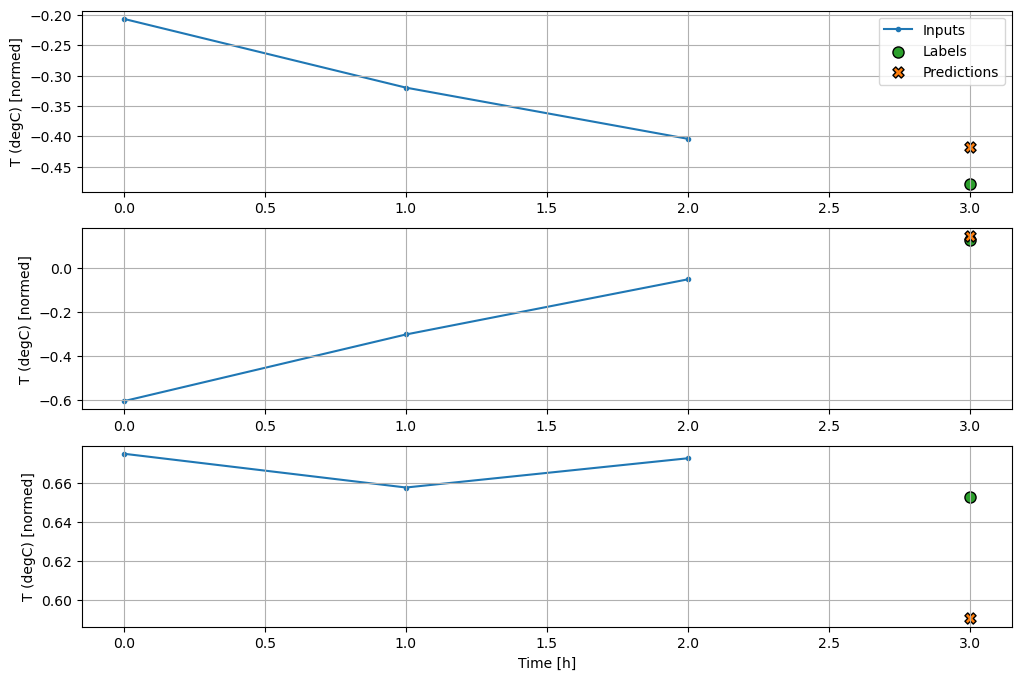

In [36]:
conv_window.plot(multi_step_dense)

## Convolutional Neural Network
We will now try using a conv1d layer

In [37]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
    kernel_size=(CONV_WIDTH,),activation='relu'),
    tf.keras.layers.Dense(units=32,activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [38]:
history=compile_and_fit(conv_model,conv_window)

IPython.display.clear_output()
val_performance['Conv']=conv_model.evaluate(conv_window.val)
performance['Conv']=conv_model.evaluate(conv_window.test,verbose=0)

438/438 [==============================] - 1s 2ms/step - loss: 0.0068 - mean_absolute_error: 0.0592


In [39]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window=WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)']
)
wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

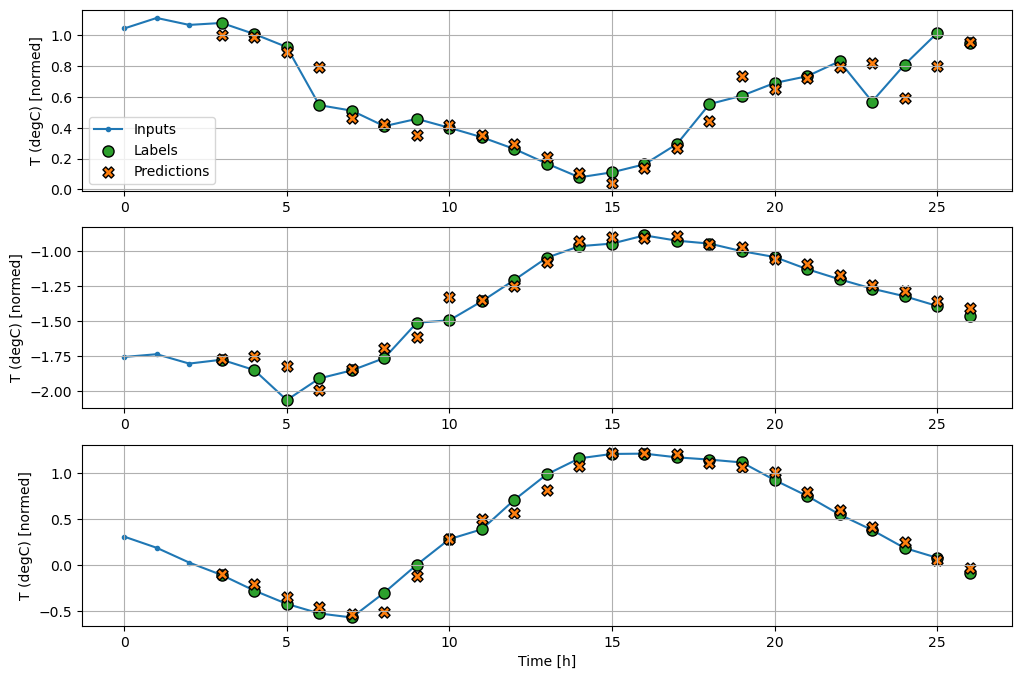

In [40]:
wide_conv_window.plot(conv_model)

As seen, the CNN is fairly good, and much better than the linear network. Next up is the RNN!
# RNN
A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step. 
For this we will use a Long Short Term Memory(LSTM) network.

In [41]:
lstm_model=tf.keras.Sequential([
    tf.keras.layers.LSTM(32,return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [42]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 2s 4ms/step - loss: 0.0056 - mean_absolute_error: 0.0514


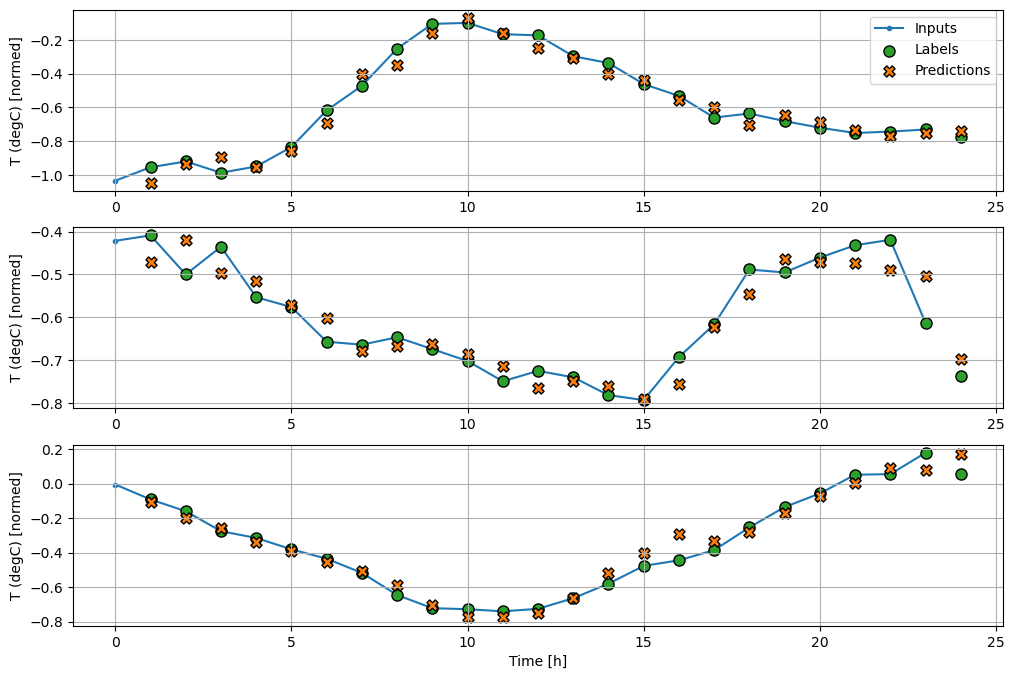

In [43]:
wide_window.plot(lstm_model)

## Performance
We will now look at the different model's performances.

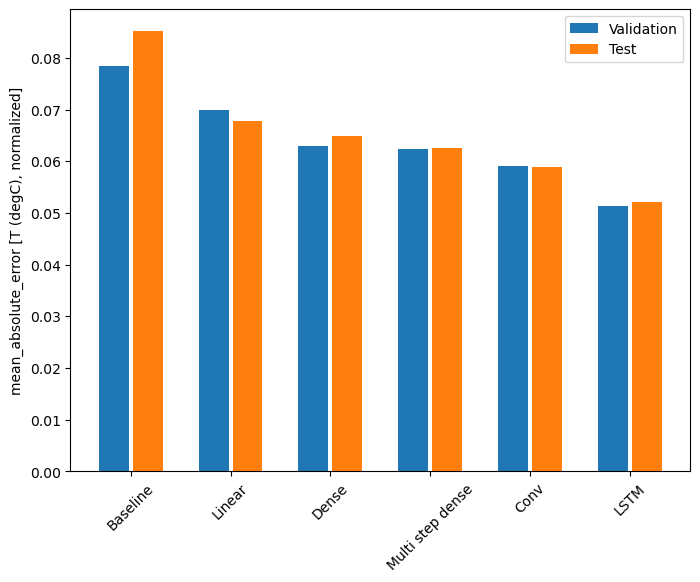

In [44]:
x= np.arange(len(performance))
width=0.3
metric_name='mean_absolute_error'
metric_index=lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [45]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0679
Dense       : 0.0649
Multi step dense: 0.0626
Conv        : 0.0590
LSTM        : 0.0521


# Multiple output
Instead of just having a single output we will now increase to have 24 outputs,i.e. predict all values.

In [46]:
wide_window = WindowGenerator(input_width=24,label_width=24,shift=1)

In [47]:
baseline= Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [48]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 1ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


In [49]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [50]:
history = compile_and_fit(dense, wide_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(wide_window.val)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 2ms/step - loss: 0.0659 - mean_absolute_error: 0.1225


In [51]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)


438/438 [==============================] - 2s 5ms/step - loss: 0.0615 - mean_absolute_error: 0.1200


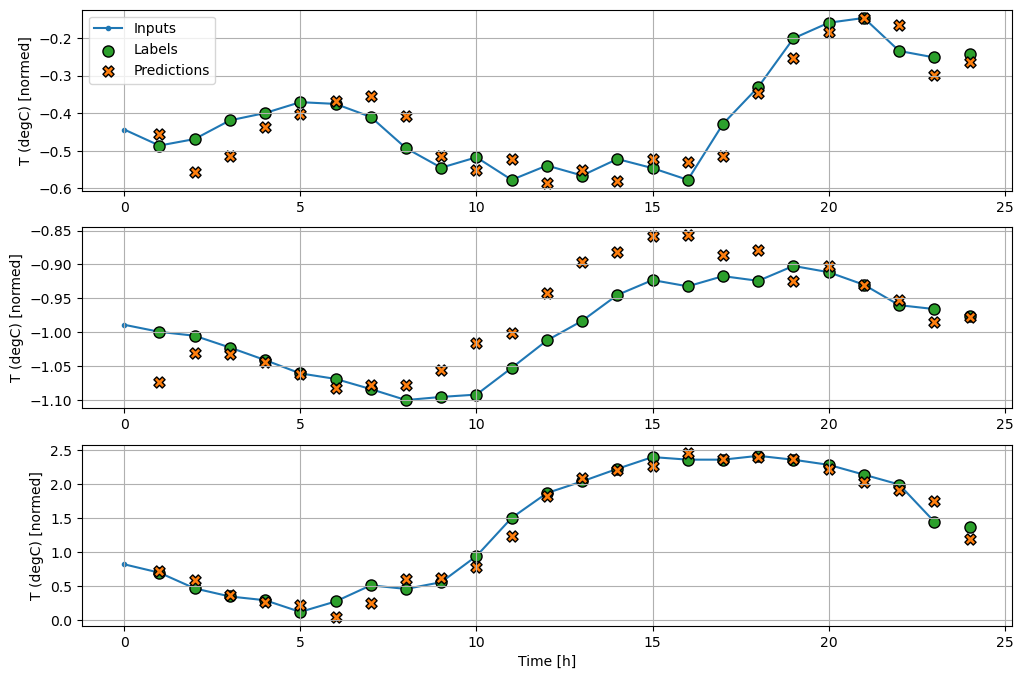

In [52]:
wide_window.plot(lstm_model)

# recap
This jupyter notebook has tested RNN and CNN and Dense models so that they predict the temperature(or all features for LSTM and dense) for one timestep at a time.
Since the CNN requires a sliding window, it has a warmup period of 3 points(hours), as is visible in its plots.The next steps can be to require the model to output the full 24 hours instead of just 1h at a time.